In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [2]:
# cudaが使えるか確認
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

データの読み込み

GPUで作ったPickleのファイルは，CPUではそのままでは使えないため，工夫が必要．

https://www.kunita-gamefactory.com/post/%E3%80%90pytorch%E3%80%91gpu%E3%81%A7%E8%A8%93%E7%B7%B4%E3%81%95%E3%81%9B%E3%81%9F%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92cpu%E3%81%A7%E8%AA%AD%E3%81%BF%E8%BE%BC%E3%82%82%E3%81%86%E3%81%A8%E3%81%97%E3%81%9F%E3%81%8A%E8%A9%B1

を真似したらうまくCPU上でもファイルを読み込むことができるようになった．

In [3]:
import io
        
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [4]:
# ファイルの相対パスを指定
file_path = 'Data/Ising_samp_data_L16.pkl'

if torch.cuda.is_available():
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file, encoding='latin1')
else:
    with open(file_path, 'rb') as file:
        loaded_data = CPU_Unpickler(file).load()
        
# 読み込んだデータを個々の変数に分割
spin_data, temp_data = loaded_data

In [5]:
# データの形を確認
spin_data.shape , len(temp_data)

(torch.Size([25000, 16, 16]), 25000)

In [6]:
spin_data = spin_data.unsqueeze(1)
spin_data.shape

torch.Size([25000, 1, 16, 16])

In [7]:
print(spin_data[10000], temp_data[10000])

tensor([[[-1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
          -1., -1.],
         [-1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
           1., -1.],
         [-1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
           1., -1.],
         [-1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,
           1.,  1.],
         [-1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,
          -1.,  1.],
         [-1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
          -1.,  1.],
         [ 1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
           1.,  1.],
         [-1., -1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
           

In [8]:
# サンプルデータを訓練用とテスト用に分割(5:5)
spin_train, spin_test, temp_train, temp_test = train_test_split(spin_data, temp_data, test_size=0.5)

In [9]:
# PyTorchのテンソルに変換
spin_train = torch.tensor(spin_train, dtype=torch.float32)
spin_test = torch.tensor(spin_test, dtype=torch.float32)
temp_train = torch.tensor(temp_train, dtype=torch.float32).view(-1, 1)  # (25000,) -> (25000, 1)
temp_test = torch.tensor(temp_test, dtype=torch.float32).view(-1, 1)    # (6250,) -> (6250, 1)

C:\Users\soken\AppData\Local\Temp\ipykernel_15724\3927323180.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_train = torch.tensor(spin_train, dtype=torch.float32)
C:\Users\soken\AppData\Local\Temp\ipykernel_15724\3927323180.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_test = torch.tensor(spin_test, dtype=torch.float32)


In [10]:
spin_train[1]

tensor([[[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -

In [11]:
temp_train[1]

tensor([0.0100])

正解データはone-hot表現にする必要がある

In [12]:
# テンソルを新しいテンソルに変換する関数を定義
def to_one_hot(data, num_classes=25):
    # one-hotベクトルの初期化
    one_hot = torch.zeros(len(data), num_classes)
    
    # 各要素を25次元のone-hotベクトルに変換
    for i, val in enumerate(data):
        index = int((val - 0.01) / 0.24)  # 正しいインデックスの計算
        one_hot[i, index] = 1.0
    
    return one_hot

# temp_train,temp_testをone-hotベクトルに変換
one_hot_temp_train = to_one_hot(temp_train, num_classes=25)
one_hot_temp_test = to_one_hot(temp_test, num_classes=25)

In [13]:
one_hot_temp_train[0]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])

In [14]:
temp_train[0]

tensor([1.7500])

In [15]:
# データセットの作成
train_dataset = TensorDataset(spin_train, one_hot_temp_train)
test_dataset = TensorDataset(spin_test, one_hot_temp_test)

In [16]:
train_dataset[0]

(tensor([[[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1.,  1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
            1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [17]:
# 前処理を定義
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# データセットに前処理を適用
transformed_train_dataset = [(transform(tensor_sample), label) for tensor_sample, label in train_dataset]
transformed_test_dataset = [(transform(tensor_sample), label) for tensor_sample, label in test_dataset]

In [18]:
transformed_train_dataset[0]

(tensor([[[-1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
           -1., -1.],
          [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1

In [19]:
# DataLoaderの設定（バッチサイズ125）
train_loader = DataLoader(transformed_train_dataset, batch_size=125, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=125)

In [20]:
data_iter = iter(train_loader)
imgs, labels = next(data_iter)
labels

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [21]:
imgs.size(), labels.size()

(torch.Size([125, 1, 16, 16]), torch.Size([125, 25]))

In [22]:
x, t = next(iter(train_loader))
x.shape, t.shape

(torch.Size([125, 1, 16, 16]), torch.Size([125, 25]))

モデルを定義

In [23]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size, in_channels, out_channels):
        super().__init__()
        # 畳み込みの部分
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(1),  # 反射パディング
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=int(((input_size)**0.5)/4), bias=False),
            nn.ReLU(inplace=True),
        )
        # 全結合の部分
        self.fc = nn.Sequential(
            nn.Linear(out_channels*4*4, output_size, bias=False),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

モデルのインスタンス化

In [24]:
input_size = 16*16
output_size = 25
in_channels = 1
out_channels = 5  
model = CNN(input_size, output_size, in_channels, out_channels)
model.to(device)
# モデルの概要表示
print(model)

CNN(
  (conv): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 5, kernel_size=(3, 3), stride=(4, 4), bias=False)
    (2): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=80, out_features=25, bias=False)
    (1): Softmax(dim=1)
  )
)


損失関数と最適化アルゴリズムの設定

In [25]:
criterion = nn.CrossEntropyLoss()   # クロスエントロピー誤差
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)     # Adam,L2正則化

学習の実行

In [26]:
num_epochs = 1000
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      # outputの一番値が大きい成分
        targets = torch.argmax(targets, dim=1)  # targetの一番値が大きい成分
        running_acc += torch.mean(pred.eq(targets).float().cpu()) # predとtargetが同じになった数の平均
        optimizer.step()
    running_loss /= len(train_loader)   # 12500個の訓練データ全体での損失関数の平均
    running_acc /= len(train_loader)    # 12500個の訓練データ全体での正解率
    train_losses.append(running_loss)
    train_accs.append(running_acc)
    #
    #   test loop
    #
    test_running_loss = 0.0
    test_running_acc = 0.0
    for test_inputs, test_targets in test_loader:
        test_inputs = test_inputs.to(device)
        test_targets = test_targets.to(device)
        test_output = model(test_inputs)
        test_loss = criterion(test_output, test_targets)
        test_running_loss += test_loss.item()
        test_pred = torch.argmax(test_output, dim=1)      # outputの一番値が大きい成分
        test_targets = torch.argmax(test_targets, dim=1)  # targetの一番値が大きい成分
        test_running_acc += torch.mean(test_pred.eq(test_targets).float().cpu()) # 正解数の平均
    test_running_loss /= len(test_loader)   # 12500個の訓練データ全体での損失関数の平均
    test_running_acc /= len(test_loader)    # 12500個の訓練データ全体での正解率
    test_losses.append(test_running_loss)
    test_accs.append(test_running_acc)
        
    print("epoch: {}, loss: {}, acc: {}, test loss: {}, test acc: {}".format(epoch, running_loss, running_acc, test_running_loss, test_running_acc))

epoch: 0, loss: 3.208441812992096, acc: 0.058080002665519714, test loss: 3.1972206330299375, test acc: 0.07048000395298004
epoch: 1, loss: 3.1903899002075193, acc: 0.08128000050783157, test loss: 3.188996984958649, test acc: 0.07688002288341522
epoch: 2, loss: 3.182785279750824, acc: 0.09671998023986816, test loss: 3.1850605535507204, test acc: 0.08328001946210861
epoch: 3, loss: 3.1760920095443725, acc: 0.11184000223875046, test loss: 3.1794946575164795, test acc: 0.09671997278928757
epoch: 4, loss: 3.1673646450042723, acc: 0.12848001718521118, test loss: 3.17300509929657, test acc: 0.1124800369143486
epoch: 5, loss: 3.1574336457252503, acc: 0.13951998949050903, test loss: 3.1674408864974977, test acc: 0.11712002009153366
epoch: 6, loss: 3.148242349624634, acc: 0.15296003222465515, test loss: 3.163031656742096, test acc: 0.12152006477117538
epoch: 7, loss: 3.142060627937317, acc: 0.1573600471019745, test loss: 3.1611719346046447, test acc: 0.12520001828670502
epoch: 8, loss: 3.1380281

損失関数と正解率のグラフの作成

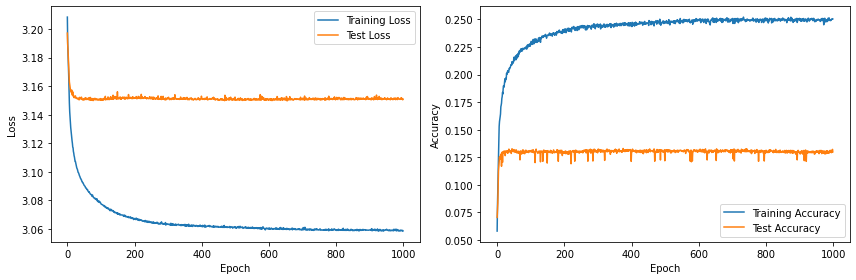

In [27]:
# グラフのプロット
plt.figure(figsize=(12, 4))

# 損失関数のグラフ
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 正解率のグラフ
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

実際に予測値と正解がどうなっているか見てみる

In [28]:
print(test_pred[:100])

tensor([ 6, 12,  6, 10, 20,  7, 13, 10,  6,  6,  6,  9, 16, 24,  0, 16,  6, 11,
         6,  6,  6, 17, 24, 21, 11,  9,  0,  6, 21, 24, 17,  7,  6, 12,  7,  6,
         6, 12, 12, 21,  7, 21, 11,  6, 11, 12, 22, 23, 20,  0,  0, 23,  9,  6,
        22,  6, 13,  0, 10, 20,  6,  6, 22,  6, 11, 10, 12, 22, 22,  0, 13, 20,
         9, 21, 12, 21,  6, 23,  7, 20,  6, 16,  9, 10, 10, 24,  6,  6, 20, 23,
         6, 12,  0, 24, 21,  6, 24, 21,  6, 16], device='cuda:0')


In [29]:
print(test_targets[:100])

tensor([ 5, 11,  3, 15, 15,  5, 17, 19,  4,  4,  8,  9, 21, 24,  0, 20,  0, 14,
         1,  4,  2, 19, 24, 24, 15,  9,  0,  5, 21, 23, 15,  7,  5, 11,  8,  2,
         5, 15, 23, 15,  9, 12, 19,  8, 11, 13, 14, 23, 14,  1,  1, 19,  9,  5,
        13,  7, 19,  1, 11, 24,  7,  3, 18,  6,  7, 11, 15, 17, 22,  0, 14, 15,
         8, 16, 14, 19,  1, 20,  6, 14,  6, 24,  9, 14, 13, 17,  1,  6, 18, 23,
         5, 24,  1, 13, 18,  8, 10, 14,  2, 18], device='cuda:0')


In [30]:
test_output.shape

torch.Size([125, 25])

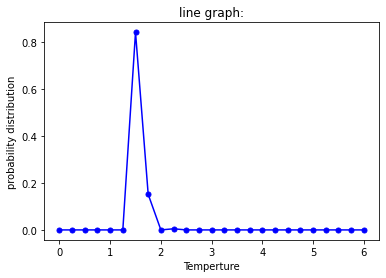

tensor(1.2500, device='cuda:0')


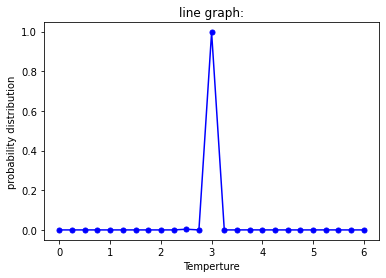

tensor(2.7500, device='cuda:0')


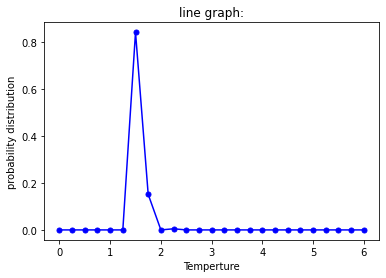

tensor(0.7500, device='cuda:0')


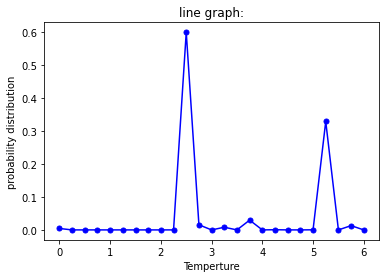

tensor(3.7500, device='cuda:0')


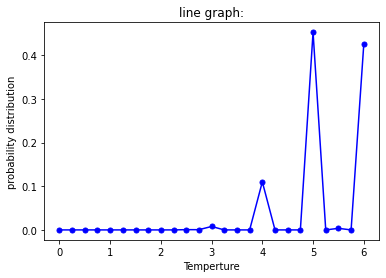

tensor(3.7500, device='cuda:0')


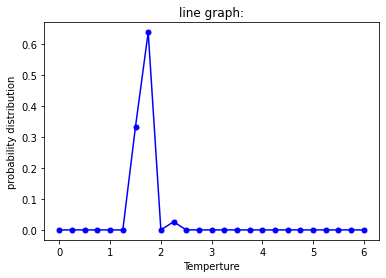

tensor(1.2500, device='cuda:0')


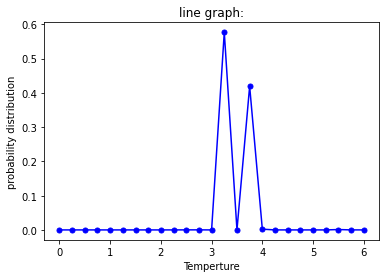

tensor(4.2500, device='cuda:0')


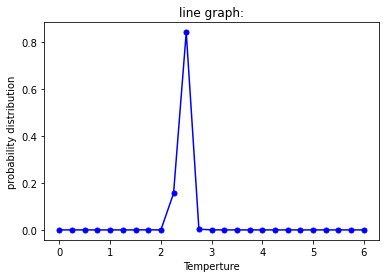

tensor(4.7500, device='cuda:0')


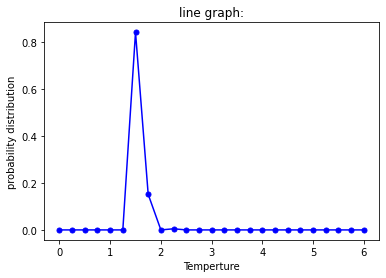

tensor(1., device='cuda:0')


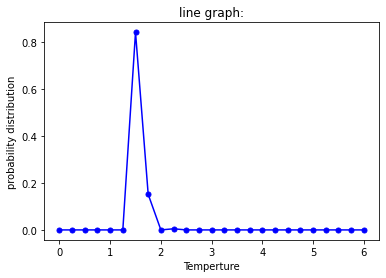

tensor(1., device='cuda:0')


In [31]:
# データのx軸値
x = [i * 0.25 for i in range(25)]

for n in range(10):
    # テンソルをホストメモリにコピーしてNumpy配列に変換
    test_output_cpu = test_output[n].detach().cpu().numpy()

    # グラフを描画
    plt.plot(x, test_output_cpu, marker='o', linestyle='-', color='b', markersize=5)

    # グラフのタイトルと軸ラベルを設定
    plt.title('line graph:')
    plt.xlabel('Temperture')
    plt.ylabel('probability distribution')

    # グラフを表示
    plt.show()

    print(test_targets[n]*0.25)


モデルの保存

In [32]:
# データを保存するディレクトリのパス
save_dir = "Data"

# ファイル名
file_name = "CNN_L16.prm"

# フルパスを作成
full_path = os.path.join(save_dir, file_name)

# パラメータを保存
torch.save(file_name, full_path)